In [ ]:
!pip install scanpy

In [ ]:
# Block 1: Setup, Mount Drive, and Define Paths

import os
import scanpy as sc
import pandas as pd
import numpy as np
import pooch # For reliable downloading
import tarfile # For decompressing .tar.gz
import gzip # For decompressing .gz if needed individually
import shutil # For file operations if needed
from google.colab import drive

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)
print("Google Drive mounted successfully.")

# --- Define Paths ---
gdrive_base_path = '/content/drive/My Drive/CMML_ICA2/'
# Directory for downloaded raw data (tar.gz and extracted mtx folder)
raw_data_parent_dir = os.path.join(gdrive_base_path, 'data_pbmc10k_mtx/raw/')
# Specific directory for the extracted MTX files for PBMC10k
pbmc10k_mtx_dir = os.path.join(raw_data_parent_dir, 'pbmc_10k_protein_v3_filtered_feature_bc_matrix') # Cell Ranger output folder name
# Directory for processed data
processed_data_dir = os.path.join(gdrive_base_path, 'data_pbmc10k_mtx/processed/')
# Directory for benchmark figures
figure_dir = os.path.join(gdrive_base_path, 'figures_pbmc10k_mtx/')

os.makedirs(raw_data_parent_dir, exist_ok=True)
os.makedirs(pbmc10k_mtx_dir, exist_ok=True) # Ensure this specific folder for extracted files also exists
os.makedirs(processed_data_dir, exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

print(f"Raw data archive will be stored in: {raw_data_parent_dir}")
print(f"Extracted MTX data will be in: {pbmc10k_mtx_dir}")
print(f"Processed data will be saved to: {processed_data_dir}")
print(f"Figures will be saved to: {figure_dir}")

# Set Scanpy settings
sc.settings.verbosity = 3
sc.settings.figdir = figure_dir
sc.set_figure_params(dpi=100, frameon=False, figsize=(5, 5), facecolor='white')

print("\nBlock 1 finished: Setup and Path Definition.")

Mounted at /content/drive
Google Drive mounted successfully.
Raw data archive will be stored in: /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/raw/
Extracted MTX data will be in: /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/raw/pbmc_10k_protein_v3_filtered_feature_bc_matrix
Processed data will be saved to: /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/processed/
Figures will be saved to: /content/drive/My Drive/CMML_ICA2/figures_pbmc10k_mtx/

Block 1 finished: Setup and Path Definition.


In [ ]:
# Block 2: Download and Extract MTX Data Archive

# --- Download PBMC10k CITE-seq MTX Archive ---
# This is the .tar.gz file you found
pbmc10k_tar_url = "https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz"
pbmc10k_tar_fname = "pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz"
pbmc10k_tar_filepath = os.path.join(raw_data_parent_dir, pbmc10k_tar_fname)

print(f"\n--- Downloading PBMC10k CITE-seq (RNA+Protein) MTX archive ---")
if not os.path.exists(pbmc10k_tar_filepath):
    try:
        pbmc10k_tar_filepath_retrieved = pooch.retrieve(
            url=pbmc10k_tar_url,
            known_hash=None, # Ideally, find and add the MD5 or SHA256 hash: "26d53ffe08b5f7d3b28df61b592d51fb" (from your screenshot for the matrix files, tar.gz hash will differ)
            fname=pbmc10k_tar_fname,
            path=raw_data_parent_dir,
        )
        print(f"Successfully downloaded {pbmc10k_tar_fname} to {raw_data_parent_dir}")
    except Exception as e:
        print(f"Failed to download {pbmc10k_tar_fname}: {e}.")
        print("Please ensure the .tar.gz file is manually placed in the raw_data_parent_dir if download fails.")
else:
    print(f"{pbmc10k_tar_fname} already exists in {raw_data_parent_dir}.")

# --- Extract the .tar.gz file ---
# The tar.gz typically extracts into a folder with the same name as the archive (minus .tar.gz)
# or a predefined folder name by Cell Ranger.
# The target folder for extraction is `pbmc10k_mtx_dir`
# We need to check if the contents (matrix.mtx.gz, barcodes.tsv.gz, features.tsv.gz) are already there.

expected_files_in_mtx_dir = [
    os.path.join(pbmc10k_mtx_dir, "matrix.mtx.gz"),
    os.path.join(pbmc10k_mtx_dir, "barcodes.tsv.gz"),
    os.path.join(pbmc10k_mtx_dir, "features.tsv.gz")
]

if all(os.path.exists(f) for f in expected_files_in_mtx_dir):
    print(f"\nExtracted MTX files already seem to exist in {pbmc10k_mtx_dir}. Skipping extraction.")
elif os.path.exists(pbmc10k_tar_filepath):
    print(f"\n--- Extracting {pbmc10k_tar_fname} to {raw_data_parent_dir} ---")
    # Note: tarfile extracts into the current working directory or a specified path.
    # We want the contents to go into `pbmc10k_mtx_dir`.
    # Cell Ranger tarballs usually have a top-level directory like 'filtered_feature_bc_matrix'.
    # We will extract to `raw_data_parent_dir` and then check if the expected folder `pbmc_10k_protein_v3_filtered_feature_bc_matrix` was created.
    try:
        with tarfile.open(pbmc10k_tar_filepath, "r:gz") as tar:
            # Check members to see the structure
            # for member in tar.getmembers():
            #     print(member.name)
            # If it extracts everything into a subfolder named 'filtered_feature_bc_matrix',
            # then our pbmc10k_mtx_dir will be that subfolder.
            tar.extractall(path=raw_data_parent_dir) # Extracts to raw_data_parent_dir
        print(f"Extraction complete. Check contents of {raw_data_parent_dir}")
        # Verify that the expected folder (pbmc10k_mtx_dir) now contains the files
        if all(os.path.exists(f) for f in expected_files_in_mtx_dir):
            print(f"Successfully extracted files into {pbmc10k_mtx_dir}")
        else:
            print(f"ERROR: Extraction might not have placed files directly into {pbmc10k_mtx_dir}.")
            print(f"Please check the contents of {raw_data_parent_dir} and ensure files are in {pbmc10k_mtx_dir}.")
            print("You might need to manually move files from an intermediate extracted folder.")
            print(f"Expected files: matrix.mtx.gz, barcodes.tsv.gz, features.tsv.gz inside {pbmc10k_mtx_dir}")

    except Exception as e:
        print(f"Error during extraction: {e}")
else:
    print(f"ERROR: {pbmc10k_tar_fname} not found. Cannot extract.")


print("\nBlock 2 finished: Data Download and Extraction Attempt.")


--- Downloading PBMC10k CITE-seq (RNA+Protein) MTX archive ---


SHA256 hash of downloaded file: a962ec958ae361ee1c8f801d15424fa9dbaae7232f74ceea5f242e3de350092c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


Successfully downloaded pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz to /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/raw/

--- Extracting pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz to /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/raw/ ---
Extraction complete. Check contents of /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/raw/
ERROR: Extraction might not have placed files directly into /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/raw/pbmc_10k_protein_v3_filtered_feature_bc_matrix.
Please check the contents of /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/raw/ and ensure files are in /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/raw/pbmc_10k_protein_v3_filtered_feature_bc_matrix.
You might need to manually move files from an intermediate extracted folder.
Expected files: matrix.mtx.gz, barcodes.tsv.gz, features.tsv.gz inside /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/raw/pbmc_10k_protein_v3_filtered_feature_bc_matrix

Block 2 f

In [ ]:
# Block 3: Load MTX Data into AnnData and Inspect feature_types

import matplotlib.pyplot as plt # For potential plotting later
import seaborn as sns # For potential plotting later

print(f"\n--- Loading PBMC10k MTX Data from {pbmc10k_mtx_dir} ---")

# Check if the MTX directory and essential files exist before attempting to read
if not os.path.isdir(pbmc10k_mtx_dir) or \
   not os.path.exists(os.path.join(pbmc10k_mtx_dir, "matrix.mtx.gz")) or \
   not os.path.exists(os.path.join(pbmc10k_mtx_dir, "barcodes.tsv.gz")) or \
   not os.path.exists(os.path.join(pbmc10k_mtx_dir, "features.tsv.gz")):
    print(f"ERROR: MTX data directory or essential files not found in {pbmc10k_mtx_dir}.")
    print("Please ensure data from Block 2 was downloaded and extracted correctly.")
    adata_raw_from_mtx = None # Initialize to None
else:
    # var_names='gene_symbols' uses the second column of features.tsv.gz (gene names)
    # cache=True can speed up subsequent loads of the same data
    adata_raw_from_mtx = sc.read_10x_mtx(
        pbmc10k_mtx_dir,
        var_names='gene_symbols', # Use gene symbols for var_names
        gex_only=False,          # IMPORTANT: Load all feature types (RNA and ADT)
        cache=True
    )
    adata_raw_from_mtx.var_names_make_unique() # Ensure unique gene/feature names
    print("PBMC10k MTX data loaded into adata_raw_from_mtx.")
    print("Initial AnnData object (adata_raw_from_mtx):")
    print(adata_raw_from_mtx)

    # --- Inspect adata_raw_from_mtx.var to understand feature types ---
    print("\n--- Inspecting adata_raw_from_mtx.var ---")
    print("Columns in adata_raw_from_mtx.var:")
    print(adata_raw_from_mtx.var.columns) # Should include 'gene_ids', 'feature_types'

    if "feature_types" in adata_raw_from_mtx.var.columns:
        print("\nUnique values and counts in adata_raw_from_mtx.var['feature_types']:")
        print(adata_raw_from_mtx.var["feature_types"].value_counts())
    else:
        print("\nCRITICAL WARNING: 'feature_types' column NOT FOUND in adata_raw_from_mtx.var after loading MTX.")
        print("This means protein features cannot be automatically distinguished from RNA.")
        print("Please check your features.tsv.gz file content and structure.")

if adata_raw_from_mtx is None:
    print("Halting execution as data loading failed.")
else:
    print("\nBlock 3 finished: MTX Data Loading and feature_type Inspection.")


--- Loading PBMC10k MTX Data from /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/raw/pbmc_10k_protein_v3_filtered_feature_bc_matrix ---
... writing an h5ad cache file to speedup reading next time
PBMC10k MTX data loaded into adata_raw_from_mtx.
Initial AnnData object (adata_raw_from_mtx):
AnnData object with n_obs × n_vars = 7865 × 33555
    var: 'gene_ids', 'feature_types'

--- Inspecting adata_raw_from_mtx.var ---
Columns in adata_raw_from_mtx.var:
Index(['gene_ids', 'feature_types'], dtype='object')

Unique values and counts in adata_raw_from_mtx.var['feature_types']:
feature_types
Gene Expression     33538
Antibody Capture       17
Name: count, dtype: int64

Block 3 finished: MTX Data Loading and feature_type Inspection.



--- Separating RNA and Protein from adata_raw_from_mtx ---
Number of Gene Expression features: 33538
Number of Antibody Capture (Protein) features: 17

Created adata_main for RNA:
AnnData object with n_obs × n_vars = 7865 × 33538
    var: 'gene_ids', 'feature_types'
Protein counts stored in adata_main.obsm['protein_counts'] with shape: (7865, 17)
Protein names stored in adata_main.uns['protein_names'] (first 5): ['CD3_TotalSeqB' 'CD4_TotalSeqB' 'CD8a_TotalSeqB' 'CD14_TotalSeqB'
 'CD15_TotalSeqB']

--- Calculating and Plotting Initial QC Metrics for adata_main ---

Calculated n_protein_counts and n_proteins. Distributions:
n_genes_by_counts describe:
count    7865.000000
mean     1585.174698
std       675.503957
min        19.000000
25%      1190.000000
50%      1394.000000
75%      1819.000000
max      6878.000000
Name: n_genes_by_counts, dtype: float64
total_counts (RNA UMIs) describe:
count     7865.000000
mean      4703.801758
std       4306.959473
min        501.000000
25%       2

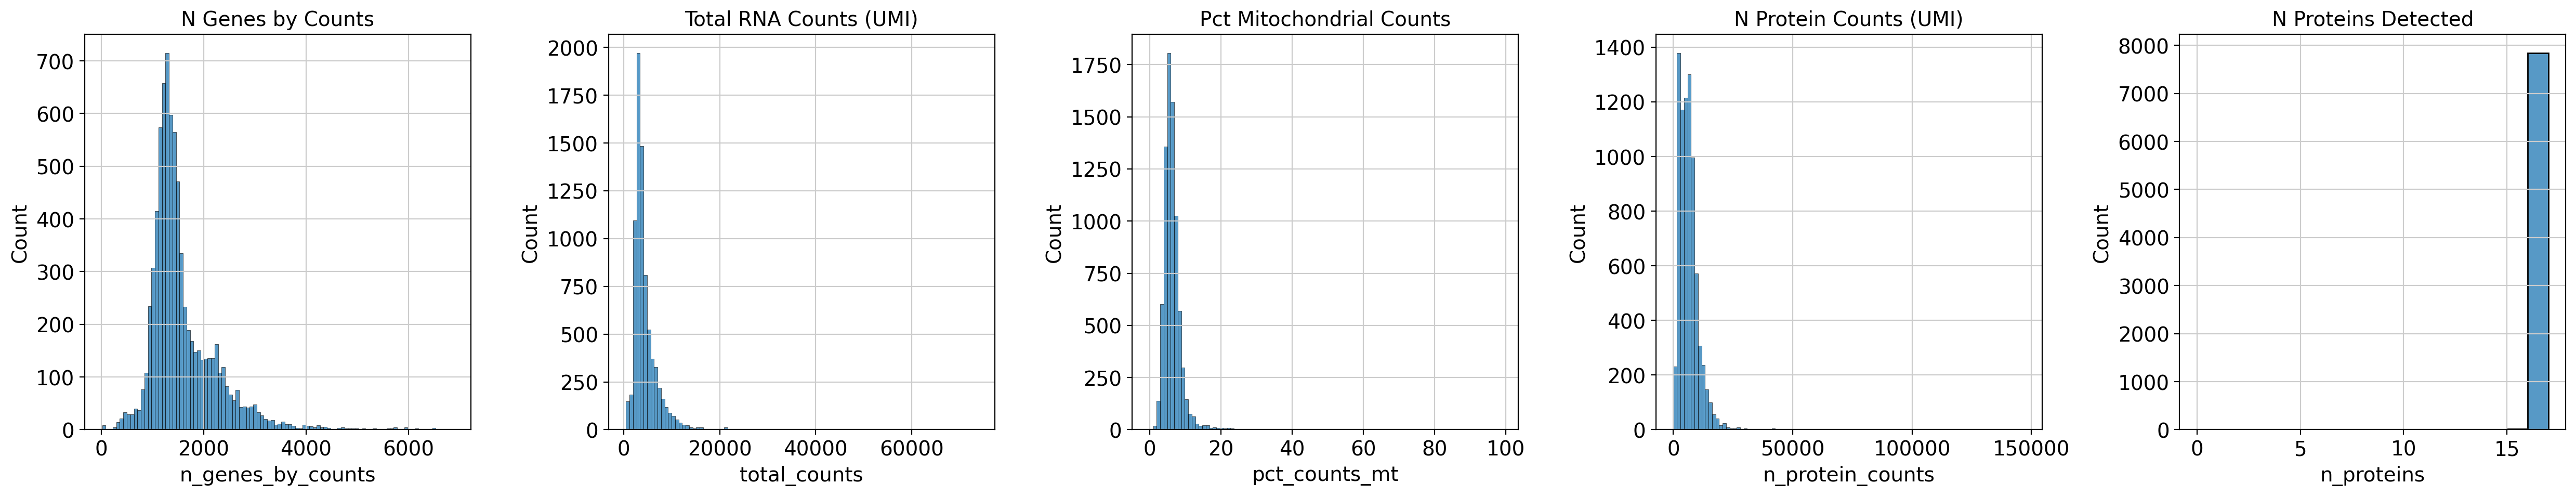


Block 4 finished: Protein Separation and Initial QC.


In [ ]:
# Block 4: Separate Protein Data, Initial QC Calculation and Plotting

import matplotlib.pyplot as plt # Ensure plt is imported if not already from Block 1/2
import seaborn as sns # Ensure seaborn is imported

print(f"\n--- Separating RNA and Protein from adata_raw_from_mtx ---")

# Define masks based on the confirmed feature_types
is_gene_mask = adata_raw_from_mtx.var["feature_types"] == "Gene Expression"
is_protein_mask = adata_raw_from_mtx.var["feature_types"] == "Antibody Capture"

print(f"Number of Gene Expression features: {is_gene_mask.sum()}")
print(f"Number of Antibody Capture (Protein) features: {is_protein_mask.sum()}")

# Create the main AnnData object for RNA
adata_main = adata_raw_from_mtx[:, is_gene_mask].copy()
print("\nCreated adata_main for RNA:")
print(adata_main)

# Extract and store protein data
if is_protein_mask.sum() > 0:
    protein_data_temp = adata_raw_from_mtx[:, is_protein_mask].copy()
    adata_main.obsm["protein_counts"] = protein_data_temp.X.toarray() if hasattr(protein_data_temp.X, "toarray") else protein_data_temp.X
    adata_main.uns["protein_names"] = protein_data_temp.var_names.to_numpy()
    print(f"Protein counts stored in adata_main.obsm['protein_counts'] with shape: {adata_main.obsm['protein_counts'].shape}")
    print(f"Protein names stored in adata_main.uns['protein_names'] (first 5): {adata_main.uns['protein_names'][:5]}")
else:
    print("WARNING: No protein features were identified to store.")
    # Create empty placeholders if needed by downstream code, though this shouldn't happen now
    adata_main.obsm["protein_counts"] = np.zeros((adata_main.n_obs, 0))
    adata_main.uns["protein_names"] = np.array([])


# --- Initial QC Metric Calculation & Plotting ---
print("\n--- Calculating and Plotting Initial QC Metrics for adata_main ---")
# Mitochondrial genes (assuming Human PBMC, prefix "MT-")
adata_main.var['mt'] = adata_main.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata_main, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Protein QC metrics (now protein_counts should have data)
if "protein_counts" in adata_main.obsm and adata_main.obsm["protein_counts"].shape[1] > 0:
    adata_main.obs['n_protein_counts'] = adata_main.obsm['protein_counts'].sum(axis=1)
    adata_main.obs['n_proteins'] = (adata_main.obsm['protein_counts'] > 0).sum(axis=1)
    print("\nCalculated n_protein_counts and n_proteins. Distributions:")
    print("n_genes_by_counts describe:")
    print(adata_main.obs['n_genes_by_counts'].describe())
    print("total_counts (RNA UMIs) describe:")
    print(adata_main.obs['total_counts'].describe())
    print("pct_counts_mt describe:")
    print(adata_main.obs['pct_counts_mt'].describe())
    print("n_protein_counts describe:")
    print(adata_main.obs['n_protein_counts'].describe())
    print("n_proteins describe:")
    print(adata_main.obs['n_proteins'].describe())

else:
    print("Protein data not found or empty in .obsm for QC calculation.")
    if 'n_protein_counts' not in adata_main.obs: adata_main.obs['n_protein_counts'] = 0
    if 'n_proteins' not in adata_main.obs: adata_main.obs['n_proteins'] = 0


# Plotting QC distributions before filtering
fig, axs = plt.subplots(1, 5, figsize=(25, 5)) # Increased to 5 plots for n_proteins
sns.histplot(adata_main.obs['n_genes_by_counts'], bins=100, kde=False, ax=axs[0])
axs[0].set_title('N Genes by Counts')
sns.histplot(adata_main.obs['total_counts'], bins=100, kde=False, ax=axs[1])
axs[1].set_title('Total RNA Counts (UMI)')
sns.histplot(adata_main.obs['pct_counts_mt'], bins=100, kde=False, ax=axs[2])
axs[2].set_title('Pct Mitochondrial Counts')

protein_counts_to_plot = adata_main.obs.get('n_protein_counts', pd.Series(0, index=adata_main.obs_names))
if protein_counts_to_plot.sum() > 0 :
  sns.histplot(protein_counts_to_plot, bins=100, kde=False, ax=axs[3])
  axs[3].set_title('N Protein Counts (UMI)')
else:
  axs[3].set_title('N Protein Counts (No data)')

n_proteins_to_plot = adata_main.obs.get('n_proteins', pd.Series(0, index=adata_main.obs_names))
if n_proteins_to_plot.sum() > 0 :
  sns.histplot(n_proteins_to_plot, bins=max(1,n_proteins_to_plot.max()), kde=False, ax=axs[4]) # Adjust bins for discrete counts
  axs[4].set_title('N Proteins Detected')
else:
  axs[4].set_title('N Proteins Detected (No data)')

plt.tight_layout()
plt.savefig(os.path.join(figure_dir, "qc_metrics_before_filtering_mtx.png"), dpi=300)
plt.show()
plt.close()

print("\nBlock 4 finished: Protein Separation and Initial QC.")


--- Applying Cell and Gene Filters (using MTX-loaded data) ---
Initial number of cells for filtering: 7865
Initial number of genes for filtering: 33538

Filtering cells by n_genes_by_counts (min: 500, max: 6000)...
Cells after n_genes_by_counts filter: 7771 (removed 94)

Filtering cells by pct_counts_mt (< 15%)...
Cells after mitochondrial DNA% filter: 7700 (removed 71)

Filtering cells based on protein metrics...
  n_protein_counts >= 1000
  n_protein_counts <= 30000
  n_proteins >= 15
Cells after all protein QC filters: 7611 (removed 89)

Filtering genes by min_cells (3)...
filtered out 15604 genes that are detected in less than 3 cells


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Number of genes after min_cells filter: 17934 (removed 15604)

AnnData object after all filtering (adata_main_filtered):
AnnData object with n_obs × n_vars = 7611 × 17934
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_protein_counts', 'n_proteins'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'protein_names'
    obsm: 'protein_counts'


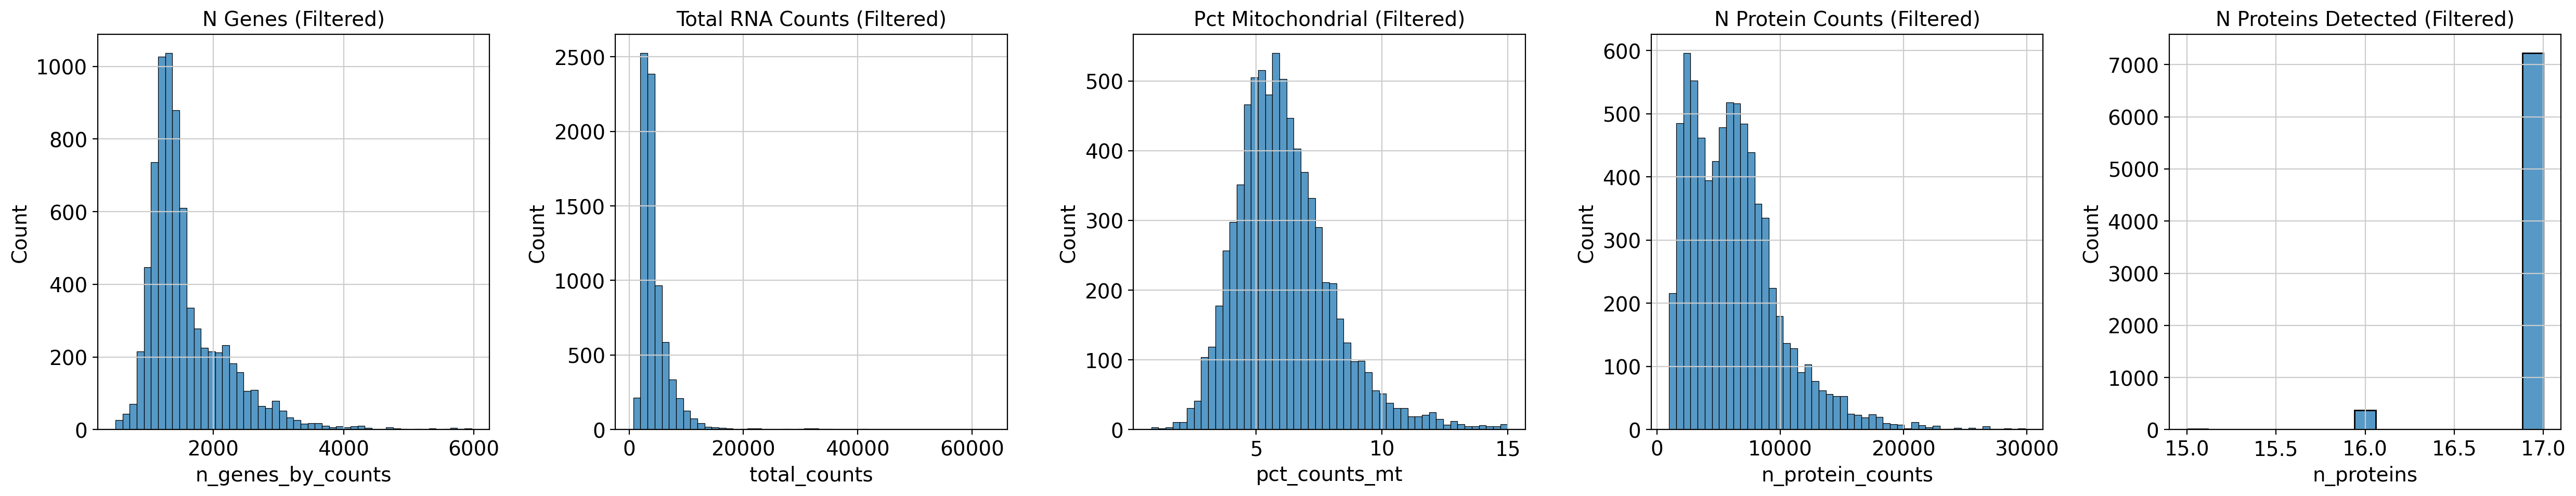


Block 5 finished: Cell and Gene Filtering.


In [ ]:
# Block 5: Cell and Gene Filtering (Based on QC Plot Analysis)

print("\n--- Applying Cell and Gene Filters (using MTX-loaded data) ---")

# --- Define QC Thresholds BASED ON YOUR PLOTS AND STATISTICS ---
min_genes_per_cell = 500    # Increased based on distribution, removes the left shoulder
max_genes_per_cell = 6000   # To remove potential doublets on the right tail
# min_counts_per_cell = 1000  # Optional, often correlated with min_genes
max_pct_mito = 15           # Keeps most cells, removes high mito cells

# Protein QC thresholds for PBMC10k CITE-seq (~17 proteins)
min_protein_counts_per_cell = 1000   # Based on n_protein_counts distribution (removes left tail)
max_protein_counts_per_cell = 30000  # To remove extreme outliers on the right tail
min_proteins_detected_per_cell = 15  # Most cells detect all/most proteins; this removes poor ADT capture

min_cells_per_gene = 3

adata_filtered = adata_main.copy() # Work on a copy for filtering

print(f"Initial number of cells for filtering: {adata_filtered.n_obs}")
print(f"Initial number of genes for filtering: {adata_filtered.n_vars}")

# --- Apply Filters ---
# 1. Filter cells by gene counts
print(f"\nFiltering cells by n_genes_by_counts (min: {min_genes_per_cell}, max: {max_genes_per_cell})...")
n_obs_before = adata_filtered.n_obs
adata_filtered = adata_filtered[adata_filtered.obs.n_genes_by_counts >= min_genes_per_cell, :]
adata_filtered = adata_filtered[adata_filtered.obs.n_genes_by_counts < max_genes_per_cell, :]
print(f"Cells after n_genes_by_counts filter: {adata_filtered.n_obs} (removed {n_obs_before - adata_filtered.n_obs})")

# Optional: Filter by total RNA counts
# n_obs_before = adata_filtered.n_obs
# adata_filtered = adata_filtered[adata_filtered.obs.total_counts >= min_counts_per_cell, :]
# print(f"Cells after min_counts_RNA ({min_counts_per_cell}) filter: {adata_filtered.n_obs} (removed {n_obs_before - adata_filtered.n_obs})")


# 2. Filter cells by mitochondrial content
print(f"\nFiltering cells by pct_counts_mt (< {max_pct_mito}%)...")
n_obs_before = adata_filtered.n_obs
adata_filtered = adata_filtered[adata_filtered.obs['pct_counts_mt'] < max_pct_mito, :]
print(f"Cells after mitochondrial DNA% filter: {adata_filtered.n_obs} (removed {n_obs_before - adata_filtered.n_obs})")

# 3. Filter cells by protein counts
if 'n_protein_counts' in adata_filtered.obs and 'n_proteins' in adata_filtered.obs and adata_filtered.n_obs > 0:
    print(f"\nFiltering cells based on protein metrics...")
    print(f"  n_protein_counts >= {min_protein_counts_per_cell}")
    print(f"  n_protein_counts <= {max_protein_counts_per_cell}")
    print(f"  n_proteins >= {min_proteins_detected_per_cell}")

    n_obs_before = adata_filtered.n_obs
    adata_filtered = adata_filtered[adata_filtered.obs['n_protein_counts'] >= min_protein_counts_per_cell, :]
    adata_filtered = adata_filtered[adata_filtered.obs['n_protein_counts'] <= max_protein_counts_per_cell, :]
    adata_filtered = adata_filtered[adata_filtered.obs['n_proteins'] >= min_proteins_detected_per_cell, :]
    print(f"Cells after all protein QC filters: {adata_filtered.n_obs} (removed {n_obs_before - adata_filtered.n_obs})")
elif adata_filtered.n_obs == 0:
    print("No cells remaining before protein QC filters.")
else:
    print("Protein QC metrics not found, skipping protein-based cell filtering.")

# 4. Filter genes expressed in too few cells
if adata_filtered.n_obs > 0:
    print(f"\nFiltering genes by min_cells ({min_cells_per_gene})...")
    n_vars_before = adata_filtered.n_vars
    sc.pp.filter_genes(adata_filtered, min_cells=min_cells_per_gene)
    print(f"Number of genes after min_cells filter: {adata_filtered.n_vars} (removed {n_vars_before - adata_filtered.n_vars})")
else:
    print("No cells remaining, skipping gene filtering.")

print("\nAnnData object after all filtering (adata_main_filtered):")
print(adata_filtered)

# --- Plot QC distributions AFTER filtering ---
if adata_filtered.n_obs > 0:
    fig, axs = plt.subplots(1, 5, figsize=(25, 5))
    # Re-calculate QC metrics on the filtered object for accurate plotting if any obs were removed
    # However, if n_genes_by_counts etc. were calculated on the original adata_main,
    # just plotting the subset of obs is fine. Let's assume current obs are correct for the subset.

    sns.histplot(adata_filtered.obs.get('n_genes_by_counts', pd.Series(0)), bins=50, kde=False, ax=axs[0])
    axs[0].set_title('N Genes (Filtered)')
    sns.histplot(adata_filtered.obs.get('total_counts', pd.Series(0)), bins=50, kde=False, ax=axs[1])
    axs[1].set_title('Total RNA Counts (Filtered)')
    sns.histplot(adata_filtered.obs.get('pct_counts_mt', pd.Series(0)), bins=50, kde=False, ax=axs[2])
    axs[2].set_title('Pct Mitochondrial (Filtered)')

    protein_counts_filtered_plot = adata_filtered.obs.get('n_protein_counts', pd.Series(0))
    sns.histplot(protein_counts_filtered_plot, bins=50, kde=False, ax=axs[3])
    axs[3].set_title('N Protein Counts (Filtered)')

    n_proteins_filtered_plot = adata_filtered.obs.get('n_proteins', pd.Series(0))
    sns.histplot(n_proteins_filtered_plot, bins=max(1,n_proteins_filtered_plot.max() if n_proteins_filtered_plot.max() > 0 else 1), kde=False, ax=axs[4])
    axs[4].set_title('N Proteins Detected (Filtered)')

    plt.tight_layout()
    plt.savefig(os.path.join(figure_dir, "qc_metrics_after_filtering_mtx.png"), dpi=300)
    plt.show()
    plt.close()
else:
    print("No cells remaining after filtering to plot QC metrics.")

print("\nBlock 5 finished: Cell and Gene Filtering.")

In [ ]:
adata_main_filtered = adata_filtered.copy() # Assign to the name we'll use going forward

In [ ]:
# (确保 raw_data_parent_dir 或 raw_data_dir 已定义并存在)
raw_data_dir = os.path.join(gdrive_base_path, 'data_pbmc10k_mtx/raw/')

truth_labels_url = "https://raw.githubusercontent.com/tarot0410/BREMSC/master/data/RealData/10X10k/truth_10X10k.csv"
truth_labels_fname = "truth_10X10k.csv"
truth_labels_path_raw = os.path.join(raw_data_dir, truth_labels_fname) # Path to save the downloaded file

print(f"\n--- Downloading Ground Truth Labels (if not already present) ---")
if not os.path.exists(truth_labels_path_raw):
    try:
        pooch.retrieve(
            url=truth_labels_url,
            known_hash=None, # Add hash if known for integrity check
            fname=truth_labels_fname,
            path=raw_data_dir, # pooch will save it as raw_data_dir/truth_labels_fname
        )
        print(f"Successfully downloaded {truth_labels_fname} to {raw_data_dir}")
    except Exception as e:
        print(f"Failed to download {truth_labels_fname}: {e}.")
        print(f"Please ensure {truth_labels_fname} is manually placed in {raw_data_dir} if download fails.")
else:
    print(f"{truth_labels_fname} already exists in {raw_data_dir}.")


--- Downloading Ground Truth Labels (if not already present) ---


SHA256 hash of downloaded file: 3ede3f6ca2f4245bb585b3b1afd4d1d9c737bcccb0424e4069979e2a6572e8a9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


Successfully downloaded truth_10X10k.csv to /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/raw/


In [ ]:
# Block 6: Merge Ground Truth Labels

print("\n--- Loading and Merging Ground Truth Cell Type Labels ---")

# Path to the downloaded ground truth file (ensure this path is correct from Block 1)
truth_labels_download_path = os.path.join(raw_data_dir, truth_labels_fname) # truth_labels_fname was "truth_10X10k.csv"

if not os.path.exists(truth_labels_download_path):
    print(f"ERROR: Ground truth file {truth_labels_download_path} not found. Please check Block 1's download.")
    # Or re-run the download part of Block 1 if needed
else:
    truth_df = pd.read_csv(truth_labels_download_path)
    print(f"Loaded ground truth labels from {truth_labels_download_path}. Shape: {truth_df.shape}. Head:")
    print(truth_df.head())

    # Ensure the barcode column name in truth_df is 'Barcode' (as per your previous message)
    # If it's different, adjust "Barcode" below.
    if "Barcode" not in truth_df.columns:
        print("ERROR: 'Barcode' column not found in truth_df. Please check the CSV file header.")
    else:
        # --- Prepare for merging ---
        # Create a temporary DataFrame from adata_main_filtered.obs for robust merging
        obs_df_for_merge = pd.DataFrame(index=adata_main_filtered.obs_names)

        # Rename columns in truth_df to avoid potential conflicts and for clarity
        truth_df_renamed = truth_df.rename(columns={"Barcode": "cell_barcode_gt", "trueType": "ground_truth_raw"})

        # --- Merge ---
        # Merge based on index of obs_df_for_merge (which is adata_main_filtered.obs_names)
        # and the 'cell_barcode_gt' column of truth_df_renamed.
        adata_obs_with_gt = obs_df_for_merge.merge(
            truth_df_renamed,
            left_index=True,
            right_on="cell_barcode_gt",
            how="left" # Keep all cells from adata_main_filtered
        )

        # --- Assign merged labels back to adata_main_filtered.obs ---
        # First, ensure the merged DataFrame's index is correctly set back to adata_main_filtered.obs_names
        # This might not be strictly necessary if left_index=True worked as expected, but it's a safeguard.
        if not adata_obs_with_gt.index.equals(adata_main_filtered.obs_names) and "cell_barcode_gt" in adata_obs_with_gt.columns:
             # If merge created a new index, we need to re-align based on original obs_names
             # This path is less likely if left_index=True and right_on='cell_barcode_gt' is used with truth_df not indexed.
             # A simpler way after merge is often:
             # temp_map = pd.Series(truth_df_renamed.ground_truth_raw.values, index=truth_df_renamed.cell_barcode_gt.values)
             # adata_main_filtered.obs["ground_truth_cell_type"] = adata_main_filtered.obs_names.map(temp_map)
             # Let's stick to the merge and then assign, making sure index is correct for assignment.
             # The merge result `adata_obs_with_gt` will have `cell_barcode_gt` as a column if `right_on` was used.
             # We need to make sure we are assigning the 'ground_truth_raw' column correctly.

             # If merge didn't set the index as obs_names, re-index it before assigning.
             # This is usually needed if you merge two DataFrames where neither is indexed by what you map on.
             # However, since we used left_index=True for obs_df_for_merge, its index should be preserved.
             # The result of the merge will have the index from the left DataFrame.
            pass # Index should be correct from left_index=True

        adata_main_filtered.obs["ground_truth_cell_type"] = adata_obs_with_gt["ground_truth_raw"].values


        # --- Check mapping success ---
        n_mapped = adata_main_filtered.obs["ground_truth_cell_type"].notna().sum()
        n_total_filtered = adata_main_filtered.n_obs
        print(f"\nMapped ground truth labels to {n_mapped} out of {n_total_filtered} filtered cells.")

        if n_mapped < n_total_filtered:
            unmapped_count = n_total_filtered - n_mapped
            print(f"WARNING: {unmapped_count} cells did not have a matching barcode in the truth file.")
            adata_main_filtered.obs["ground_truth_cell_type"].fillna("Unknown_GT_Unmapped", inplace=True)
            print(f"  Filled {unmapped_count} unmapped cells with 'Unknown_GT_Unmapped'.")

        print("\nValue counts of ground_truth_cell_type in adata_main_filtered.obs:")
        print(adata_main_filtered.obs["ground_truth_cell_type"].value_counts(dropna=False))

        # Optional: Filter out cells that couldn't be mapped or are 'unknown' from the GT file itself.
        # This depends on your strategy for handling "unknown" cells from the truth file.
        # initial_cells_before_gt_unknown_filter = adata_main_filtered.n_obs
        # known_gt_labels = ~adata_main_filtered.obs["ground_truth_cell_type"].isin(["Unknown_GT_Unmapped", "unknown"]) # Assuming "unknown" is a label in the CSV
        # adata_main_filtered = adata_main_filtered[known_gt_labels, :].copy()
        # print(f"Cells after removing 'Unknown_GT_Unmapped' or 'unknown' from ground truth: {adata_main_filtered.n_obs} (removed {initial_cells_before_gt_unknown_filter - adata_main_filtered.n_obs})")

print("\nBlock 6 finished: Ground Truth Label Merging.")
print("adata_main_filtered with ground truth labels:")
print(adata_main_filtered)
if "ground_truth_cell_type" in adata_main_filtered.obs:
    print(adata_main_filtered.obs["ground_truth_cell_type"].head())


--- Loading and Merging Ground Truth Cell Type Labels ---
Loaded ground truth labels from /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/raw/truth_10X10k.csv. Shape: (7865, 2). Head:
              Barcode         trueType
0  AAACCCAAGATTGTGA-1  CD14+ monocytes
1  AAACCCACATCGGTTA-1          unknown
2  AAACCCAGTACCGCGT-1  CD14+ monocytes
3  AAACCCAGTATCGAAA-1         NK cells
4  AAACCCAGTCGTCATA-1         NK cells

Mapped ground truth labels to 7611 out of 7611 filtered cells.

Value counts of ground_truth_cell_type in adata_main_filtered.obs:
ground_truth_cell_type
CD4+ T cells       2433
CD14+ monocytes    1555
CD8+ T cells       1087
unknown            1072
NK cells            807
B cells             586
Dendritic cells      38
CD16+ monocytes      33
Name: count, dtype: int64

Block 6 finished: Ground Truth Label Merging.
adata_main_filtered with ground truth labels:
AnnData object with n_obs × n_vars = 7611 × 17934
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt

In [ ]:
!pip install scikit-misc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Block 7: Normalization and Highly Variable Gene Selection

print("\n--- Normalization and Highly Variable Gene Selection ---")

# Ensure adata_main_filtered exists and has cells/genes
if adata_main_filtered is None or adata_main_filtered.n_obs == 0 or adata_main_filtered.n_vars == 0:
    print("ERROR: adata_main_filtered is not properly initialized or is empty. Stopping.")
else:
    # --- Store raw RNA counts in a layer before normalization ---
    # This is crucial for models like totalVI that prefer raw counts for their statistical model.
    # Also useful if you want to revert or use raw counts for other purposes later.
    if "counts" not in adata_main_filtered.layers: # Only if not already present from some other step
        adata_main_filtered.layers["counts"] = adata_main_filtered.X.copy()
        print("Stored raw RNA counts in adata_main_filtered.layers['counts']")
    else:
        print("'counts' layer already exists.")


    # --- Normalize and log-transform RNA data in .X ---
    # This will modify adata_main_filtered.X
    # This is for general use (e.g., PCA, Seurat visualization, standard DE tests)
    print("\nNormalizing total counts per cell and log-transforming RNA data...")
    sc.pp.normalize_total(adata_main_filtered, target_sum=1e4) # Normalize to 10,000 reads per cell
    sc.pp.log1p(adata_main_filtered) # log(X + 1)
    print("RNA data in .X normalized and log1p transformed.")


    # --- Select Highly Variable Genes (using the 'counts' layer) ---
    # We will mark them in .var['highly_variable'].
    # No batch_key is used here as we are treating the PBMC10k dataset as a single batch
    # for the purpose of this vertical integration benchmark.
    print("\nSelecting Highly Variable Genes...")
    if "counts" in adata_main_filtered.layers:
        sc.pp.highly_variable_genes(
            adata_main_filtered,
            layer="counts",       # Use the raw counts for HVG selection
            n_top_genes=4000,     # A common number, can be tuned
            flavor="seurat_v3",   # A robust method for HVG selection
            subset=False          # Mark genes in .var, do not subset adata yet
        )
        print(f"Identified {adata_main_filtered.var['highly_variable'].sum()} highly variable genes.")
        print("Top 5 rows of .var showing 'highly_variable' status:")
        print(adata_main_filtered.var[['highly_variable']].head())
    else:
        print("ERROR: 'counts' layer not found. Cannot select HVGs. Ensure Block 5 ran correctly or .X contains raw counts.")

print("\nBlock 7 finished: Normalization and HVG Selection.")
print(adata_main_filtered)


--- Normalization and Highly Variable Gene Selection ---
'counts' layer already exists.

Normalizing total counts per cell and log-transforming RNA data...
normalizing counts per cell
    finished (0:00:00)
RNA data in .X normalized and log1p transformed.

Selecting Highly Variable Genes...
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
Identified 4000 highly variable genes.
Top 5 rows of .var showing 'highly_variable' status:
            highly_variable
AL627309.1            False
AL669831.5            False
LINC00115             False
FAM41C                False
NOC2L                 False

Block 7 finished: Normalization and HVG Selection.
AnnData object with n_obs × n_vars = 7611 × 17934
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_co

In [ ]:
# Block 8: Saving Final Processed Data

print("\n--- Saving Final Processed Data ---")

if adata_main_filtered is None or adata_main_filtered.n_obs == 0:
    print("ERROR: adata_main_filtered is empty or not defined. Cannot save.")
else:
    # --- 1. Save the fully processed AnnData object as H5AD ---
    # This object contains:
    #   .X: normalized, log1p-transformed RNA expression
    #   .layers['counts']: raw RNA counts
    #   .obsm['protein_counts']: raw protein counts
    #   .uns['protein_names']: names of proteins
    #   .var['highly_variable']: boolean mask for HVGs
    #   .obs: various QC metrics and 'ground_truth_cell_type'
    final_h5ad_path = os.path.join(processed_data_dir, "pbmc10k_cite_seq_processed_for_totalVI.h5ad")
    try:
        adata_main_filtered.write_h5ad(final_h5ad_path, compression="lzf")
        print(f"Final processed AnnData object saved to: {final_h5ad_path}")
    except Exception as e:
        print(f"Error saving final H5AD: {e}")


    # --- 2. Save data in formats for Seurat (R) and PCA ---
    export_dir_seurat_pca = os.path.join(processed_data_dir, "pbmc10k_for_SeuratPCA_preprocessed")
    os.makedirs(export_dir_seurat_pca, exist_ok=True)

    #    a. RNA data for Seurat/PCA:
    print("\nExporting RNA data for Seurat/PCA...")
    if "counts" in adata_main_filtered.layers and \
       "highly_variable" in adata_main_filtered.var and \
       adata_main_filtered.var['highly_variable'].sum() > 0: # Ensure there are HVGs

        # Create a temporary AnnData object containing only HVGs and their raw counts in .X
        # This makes export to 10x MTX format straightforward.
        hvg_mask = adata_main_filtered.var["highly_variable"]
        temp_rna_export_adata = sc.AnnData(
            X=adata_main_filtered[:, hvg_mask].layers["counts"].copy(), # Raw counts of HVGs
            obs=adata_main_filtered.obs.copy(), # All cell metadata
            var=adata_main_filtered.var[hvg_mask].copy() # Var metadata for HVGs
        )
        print(f"Created temporary AnnData for RNA export with shape: {temp_rna_export_adata.shape}")

        rna_mtx_export_dir = os.path.join(export_dir_seurat_pca, "rna_hvg_counts_mtx")
        os.makedirs(rna_mtx_export_dir, exist_ok=True)

        try:
            import gzip
            from scipy.io import mmwrite
            from scipy.sparse import csr_matrix, csc_matrix, issparse

            matrix_to_write = temp_rna_export_adata.X
            # Ensure matrix is sparse for mmwrite, typically CSR for features x cells (transposed for genes x cells)
            if not issparse(matrix_to_write):
                matrix_to_write = csr_matrix(matrix_to_write)

            # For 10x MTX format, matrix should be features (genes) x cells for mmwrite's input if not transposed
            # Scanpy's sc.write does this, but if writing manually:
            # mmwrite expects features x observations. Our AnnData is obs x features.
            # So we write matrix_to_write.T
            with gzip.open(os.path.join(rna_mtx_export_dir, "matrix.mtx.gz"), "wb") as f:
                mmwrite(f, matrix_to_write.T) # Transpose to genes x cells

            pd.DataFrame(temp_rna_export_adata.obs_names).to_csv(
                os.path.join(rna_mtx_export_dir, "barcodes.tsv.gz"), sep='\t', header=False, index=False, compression="gzip"
            )
            # features.tsv for 10x: ID, name, type
            features_df_rna_export = pd.DataFrame({
                # Column 1: Typically Ensembl ID or unique gene ID. Using var_names if no separate ID.
                # Column 2: Gene symbol.
                # Column 3: Feature type.
                "id": temp_rna_export_adata.var_names,
                "name": temp_rna_export_adata.var_names, # Assuming var_names are gene symbols
                "type": ["Gene Expression"] * temp_rna_export_adata.n_vars
            })
            features_df_rna_export.to_csv(
                os.path.join(rna_mtx_export_dir, "features.tsv.gz"), sep='\t', header=False, index=False, compression="gzip"
            )
            print(f"RNA (HVG raw counts) saved in MTX format to: {rna_mtx_export_dir}")
        except Exception as e:
            print(f"Error saving RNA in MTX format: {e}")
            import traceback
            traceback.print_exc() # Print full traceback for debugging
    else:
        print("Could not export RNA in MTX format (missing 'counts' layer, 'highly_variable' var annotation, or no HVGs found).")

    #    b. Protein data for Seurat/PCA: Export raw protein counts as CSV
    if "protein_counts" in adata_main_filtered.obsm and "protein_names" in adata_main_filtered.uns:
        protein_df_to_export = pd.DataFrame(
            adata_main_filtered.obsm["protein_counts"], # Use raw protein counts
            index=adata_main_filtered.obs_names,
            columns=adata_main_filtered.uns["protein_names"]
        )
        protein_csv_export_path = os.path.join(export_dir_seurat_pca, "protein_counts_raw.csv")
        protein_df_to_export.to_csv(protein_csv_export_path)
        print(f"Raw Protein counts saved as CSV to: {protein_csv_export_path}")
    else:
        print("Protein data not found in .obsm, skipping CSV export for protein.")

    #    c. Cell metadata (obs), including ground truth labels
    if adata_main_filtered.n_obs > 0 :
        cell_metadata_export_path = os.path.join(export_dir_seurat_pca, "cell_metadata_filtered.csv")
        adata_main_filtered.obs.to_csv(cell_metadata_export_path)
        print(f"Cell metadata (obs) saved as CSV to: {cell_metadata_export_path}")

print("\nBlock 8 finished: Final Data Saving.")
print(f"\nFinal processed AnnData for analysis (adata_main_filtered):\n{adata_main_filtered}")
if "ground_truth_cell_type" in adata_main_filtered.obs:
    print("\nGround truth cell type distribution in final filtered data:")
    print(adata_main_filtered.obs["ground_truth_cell_type"].value_counts(dropna=False))


--- Saving Final Processed Data ---
Final processed AnnData object saved to: /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/processed/pbmc10k_cite_seq_processed_for_totalVI.h5ad

Exporting RNA data for Seurat/PCA...
Created temporary AnnData for RNA export with shape: (7611, 4000)
RNA (HVG raw counts) saved in MTX format to: /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/processed/pbmc10k_for_SeuratPCA_preprocessed/rna_hvg_counts_mtx
Raw Protein counts saved as CSV to: /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/processed/pbmc10k_for_SeuratPCA_preprocessed/protein_counts_raw.csv
Cell metadata (obs) saved as CSV to: /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/processed/pbmc10k_for_SeuratPCA_preprocessed/cell_metadata_filtered.csv

Block 8 finished: Final Data Saving.

Final processed AnnData for analysis (adata_main_filtered):
AnnData object with n_obs × n_vars = 7611 × 17934
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_prot